In [7]:
import pandas as pd
import psycopg2 as pg
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

conn = pg.connect(
    host=os.getenv('DB_HOST', 'localhost'),
    database=os.getenv('DB_NAME', 'postgres'),
    user=os.getenv('DB_USER', 'postgres'),
    password=os.getenv('DB_PASSWORD'),
    port=os.getenv('DB_PORT', '5432')
)

cursor = conn.cursor()

# --- 1. List all unique cities where customer are located ---

query = """ SELECT DISTINCT customer_city FROM customers ORDER BY customer_city; """

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["cities"])

print(df)


                   cities
0     abadia dos dourados
1               abadiania
2                  abaete
3              abaetetuba
4                 abaiara
...                   ...
4114             xinguara
4115          xique-xique
4116             zacarias
4117              ze doca
4118               zortea

[4119 rows x 1 columns]


In [3]:
# --- 2. Count the number of orders placed in 2017 ---

query = """ SELECT COUNT(order_id) FROM orders WHERE order_purchase_timestamp LIKE '%2017%'; """

cursor.execute(query)

data = cursor.fetchall()

print("total orders placed in 2017 are", data[0][0])


total orders placed in 2017 are 45101


In [4]:
# --- 3. Find the total sales per category ---

query = """ select upper(products.product_category) category,
sum(payments.payment_value) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category;
"""

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])

print(df)

                     Category       Sales
0   AGRO INDUSTRIA E COMERCIO   118730.61
1                         ART    30992.93
2             ARTS AND CRAFTS     2326.17
3                       AUDIO    60324.62
4                  AUTOMOTIVE   852294.33
..                        ...         ...
69           STATIONARY STORE   317440.07
70            TECHNICAL BOOKS    24915.44
71                  TELEPHONY   486882.05
72                       TOYS   619037.69
73            WATCHES PRESENT  1429216.68

[74 rows x 2 columns]


In [5]:
# --- 4. Calculate the percentage of orders that made in installments

query = """ select round(sum(case when payment_installments >= 1 then 1 else 0 end)/
count(*)::NUMERIC,7)*100 from payments; """

cursor.execute(query)

data = cursor.fetchall()

print("the percentage of orders that were paid in installments is", data[0])


the percentage of orders that were paid in installments is (Decimal('99.9980700'),)


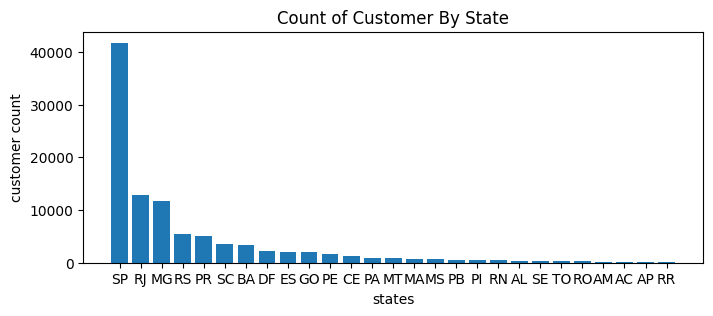

In [9]:
# --- 5. count the number of customer from each state ---

query = """ select customer_state, count(customer_id)
from customers group by customer_state
"""

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xlabel("states")
plt.ylabel("customer count")
plt.title("Count of Customer By State")

plt.show()

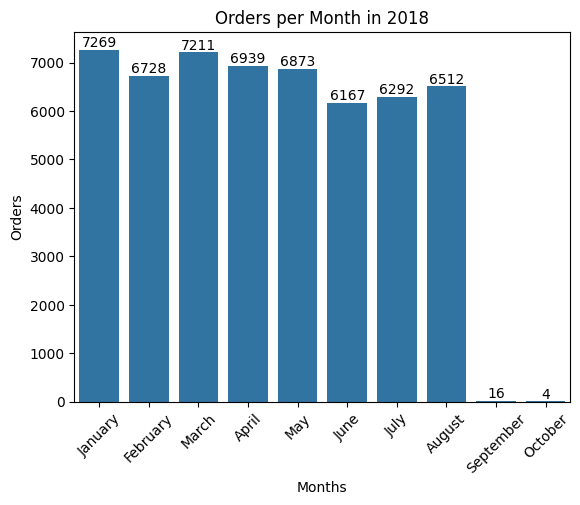

In [10]:
# --- 6. Calculate the number of orders per month in 2018 ---

query = """ select EXTRACT(MONTH FROM DATE(order_purchase_timestamp))::INTEGER as m, count(order_id) from orders
where EXTRACT(YEAR FROM DATE(order_purchase_timestamp)) = '2018'
group by m;
"""

cursor.execute(query)

data = cursor.fetchall()

df = pd.DataFrame(data,columns = ["Month", "Orders" ])
df["Months"] = df["Month"].apply(lambda x: calendar.month_name[x])
df.drop(columns=['Month'], inplace=True)  
df = df[["Months", "Orders"]]
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax = sns.barplot(data=df, x="Months", y="Orders", order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Orders per Month in 2018")

plt.show()

In [12]:
# --- 7. Find the average number of products per order, grouped by customer city ---

query = """ select customer_city, round(count(product_id) / count(distinct order_items.order_id)::NUMERIC,2)
from order_items
join orders on order_items.order_id = orders.order_id
join customers on orders.customer_id = customers.customer_id
group by customer_city order by round desc; """

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["City", "Average Products per Order"])

print(df)

                         City Average Products per Order
0              padre carvalho                       7.00
1                 celso ramos                       6.50
2               candido godoi                       6.00
3                       datas                       6.00
4              matias olimpio                       5.00
...                       ...                        ...
4105                 montadas                       1.00
4106                montanhas                       1.00
4107                 montauri                       1.00
4108  monte alegre de sergipe                       1.00
4109            monte alverne                       1.00

[4110 rows x 2 columns]


In [14]:
# --- 8. Calculate the percentage of total revenue contributed by each product category ---

query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments)*100)::NUMERIC,3) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
order by sales desc; """

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["Category", "% of Total Revenue Contributed"])

print(df)

                       Category % of Total Revenue Contributed
0                BED TABLE BATH                         10.698
1                 HEALTH BEAUTY                         10.353
2          COMPUTER ACCESSORIES                          9.903
3          FURNITURE DECORATION                          8.934
4               WATCHES PRESENT                          8.928
..                          ...                            ...
69                      FLOWERS                          0.014
70              HOUSE COMFORT 2                          0.011
71               CDS MUSIC DVDS                          0.007
72  FASHION CHILDREN'S CLOTHING                          0.005
73       INSURANCE AND SERVICES                          0.002

[74 rows x 2 columns]


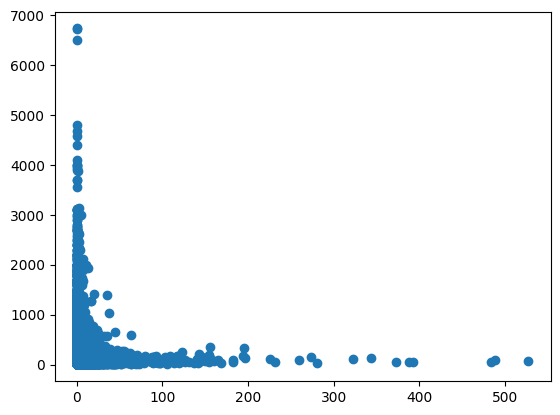

The correlation between the price and number of times a product has been purchased is -0.03213986268094528


In [15]:
# --- 9. Identify the correlation between product price and the number of times a product has been purchased. ---

query = """ select product_id, count(product_id) c, avg(price) from order_items group by product_id
order by c desc; """

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data)
x = df[1]
y = df[2]
plt.plot(x, y, 'o')
plt.show()
a = np.corrcoef(x, y)

print("The correlation between the price and number of times a product has been purchased is", a[0][1])


In [17]:
# --- 10. Calculate the total revenue generated by each seller, and rank them by revenue. ---

query = """ with a as (select seller_id, round(sum(payment_value)::NUMERIC,2) revenue from order_items
join payments on order_items.order_id = payments.order_id
group by seller_id
order by revenue desc)

select rank() over(order by revenue desc), * from a; """

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["rank", "seller_id", "revenue"])

print(df)

      rank                         seller_id    revenue
0        1  7c67e1448b00f6e969d365cea6b010ab  507166.91
1        2  1025f0e2d44d7041d6cf58b6550e0bfa  308222.04
2        3  4a3ca9315b744ce9f8e9374361493884  301245.27
3        4  1f50f920176fa81dab994f9023523100  290253.42
4        5  53243585a1d6dc2643021fd1853d8905  284903.08
...    ...                               ...        ...
3090  3091  ad14615bdd492b01b0d97922e87cb87f      19.21
3091  3092  702835e4b785b67a084280efca355756      18.56
3092  3093  4965a7002cca77301c82d3f91b82e1a9      16.36
3093  3094  77128dec4bec4878c37ab7d6169d6f26      15.22
3094  3095  cf6f6bc4df3999b9c6440f124fb2f687      12.22

[3095 rows x 3 columns]


In [18]:
# --- 11. Calculate the cumulative sales per month for each year. ---

query = """ select years, months, sales, sum(sales) over (order by years, months) cumulative_sales
from
(select TO_CHAR(TO_DATE(order_purchase_timestamp,'YYYY-MM-DD'), 'YYYY') as years,
TO_CHAR(TO_DATE(order_purchase_timestamp,'YYYY-MM-DD'), 'MM') as months,
round(sum(payment_value)::NUMERIC,2) as sales
from orders
join payments on orders.order_id = payments.order_id
group by years, months
order by years, months) as a; """

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Month", "Sales", "Cumulative Sales"])

print(df)

    Year Month       Sales Cumulative Sales
0   2016    09      252.24           252.24
1   2016    10    59090.48         59342.72
2   2016    12       19.62         59362.34
3   2017    01   138488.04        197850.38
4   2017    02   291908.01        489758.39
5   2017    03   449863.60        939621.99
6   2017    04   417788.03       1357410.02
7   2017    05   592918.82       1950328.84
8   2017    06   511276.38       2461605.22
9   2017    07   592382.92       3053988.14
10  2017    08   674396.32       3728384.46
11  2017    09   727762.45       4456146.91
12  2017    10   779677.88       5235824.79
13  2017    11  1194882.80       6430707.59
14  2017    12   878401.48       7309109.07
15  2018    01  1115004.18       8424113.25
16  2018    02   992463.34       9416576.59
17  2018    03  1159652.12      10576228.71
18  2018    04  1160785.48      11737014.19
19  2018    05  1153982.15      12890996.34
20  2018    06  1023880.50      13914876.84
21  2018    07  1066540.75      

In [19]:
# --- 12. Calculate the year-over-year growth rate of total sales. ---

query = """ WITH a AS (
    SELECT
        TO_CHAR(TO_DATE(order_purchase_timestamp, 'YYYY-MM-DD'), 'YYYY') AS years,
        round(sum(payment_value)::NUMERIC, 2) AS sales
    FROM orders
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years
),
b AS (
    SELECT years, sales, lag(sales, 1) OVER (ORDER BY years) p_sales FROM a
)
SELECT years, round(((sales - p_sales) / p_sales) * 100::NUMERIC, 2) yoy_growth FROM b; """

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["Year", "yoy % growth",])

print(df)

   Year yoy % growth
0  2016         None
1  2017     12112.70
2  2018        20.00


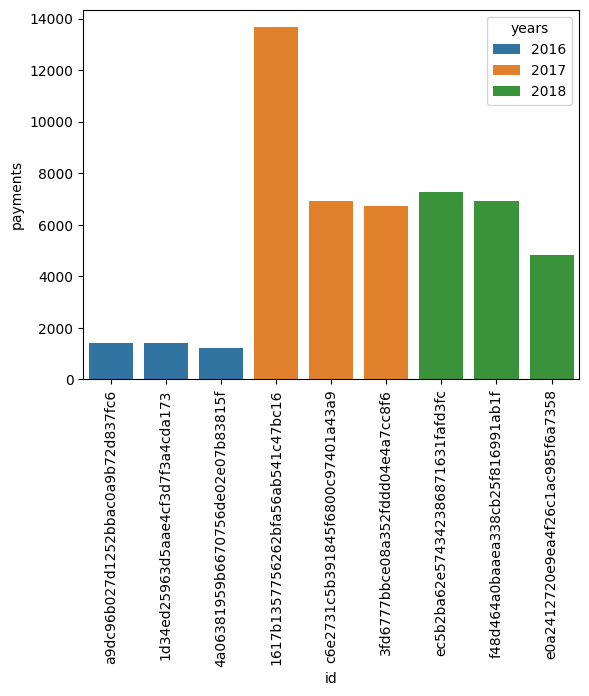

In [27]:
# --- 13. Identify the top 3 customers who spent the most money each year. ---
query = """ with a as (select TO_CHAR(TO_DATE(order_purchase_timestamp, 'YYYY-MM-DD'), 'YYYY') AS years, orders.customer_id, sum(payments.payment_value) payments,
dense_rank() over(partition by TO_CHAR(TO_DATE(order_purchase_timestamp, 'YYYY-MM-DD'), 'YYYY') order by sum(payments.payment_value) desc) d_rank from orders join payments on payments.order_id = orders.order_id group by TO_CHAR(TO_DATE(order_purchase_timestamp, 'YYYY-MM-DD'), 'YYYY'), orders.customer_id)

Select years, customer_id, payments, d_rank from a where d_rank <= 3; """

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['years', 'id', 'payments', 'rank'])
sns.barplot(x = 'id', y = 'payments', data = df, hue = 'years')
plt.xticks(rotation = 90)

plt.show()